# Tokamaker TORAX geometry comparison

This notebook is intended to isolate the differences in geometry between an eqdsk created by TokaMaker and what is retrieved from the `data_tree` results from a TORAX simulation.

TokaMaker is run by called `iter_hmode_tm.py`, see that file for specifics on the equilibrium.

TORAX is set up using the simplest possible configuration, because this notebook is only interested in the geometry after it is interpreted by TORAX, so the simulation itself doesn't matter. It is run just so there is an output object to retrieve the geometry from.

Geometry and other parameters are extracted from the eqdsk file using `TokaMaker.read_eqdsk` and from the TokaMaker object `mygs` into the `tm` dict.

Similar parameters are extracted from the TORAX output `data_tree` into the `tx` dict. Profiles are interpolated onto the `psi_N` grid using `pull_torax_onto_psi` function. This function very well might have errors but it has been checked and tested.

In [1]:
import torax
from OpenFUSIONToolkit.TokaMaker.util import read_eqdsk
import matplotlib.pyplot as plt
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
import numpy as np
import os
from scipy.interpolate import interp1d
%config InlineBackend.figure_format = "retina"


18:33:31 CRITICAL Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available. @imas_interface.py:34
2026-02-16 18:33:31,668 [CRITICAL] Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available.


In [2]:
# run TokaMaker
%run iter_hmode_tm.py

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:    main
Revision id:           51e08bd
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/9p/90ydvncx0zb8sqr976fmrfxr0000gn/T/oft_59183/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.826E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creati

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.3000E+07
  Current Centroid [m]    =    6.186  0.508
  Magnetic Axis [m]       =    6.430  0.526
  Elongation              =    1.868 (U:  1.728, L:  2.007)
  Triangularity           =    0.450 (U:  0.359, L:  0.541)
  Plasma Volume [m^3]     =   816.133
  q_0, q_95               =    1.396  3.387
  Plasma Pressure [Pa]    =   Axis:  6.1905E+05, Peak:  6.1905E+05
  Stored Energy [J]       =    2.5856E+08
  <Beta_pol> [%]          =   65.3286
  <Beta_tor> [%]          =    1.8440
  <Beta_n>   [%]          =    1.5069
  Diamagnetic flux [Wb]   =    6.3222E-01
  Toroidal flux [Wb]      =    1.2222E+02
  l_i                     =    0.8116
Saving gEQDSK: iter_hmode.eqdsk
 Using COCOS=2...


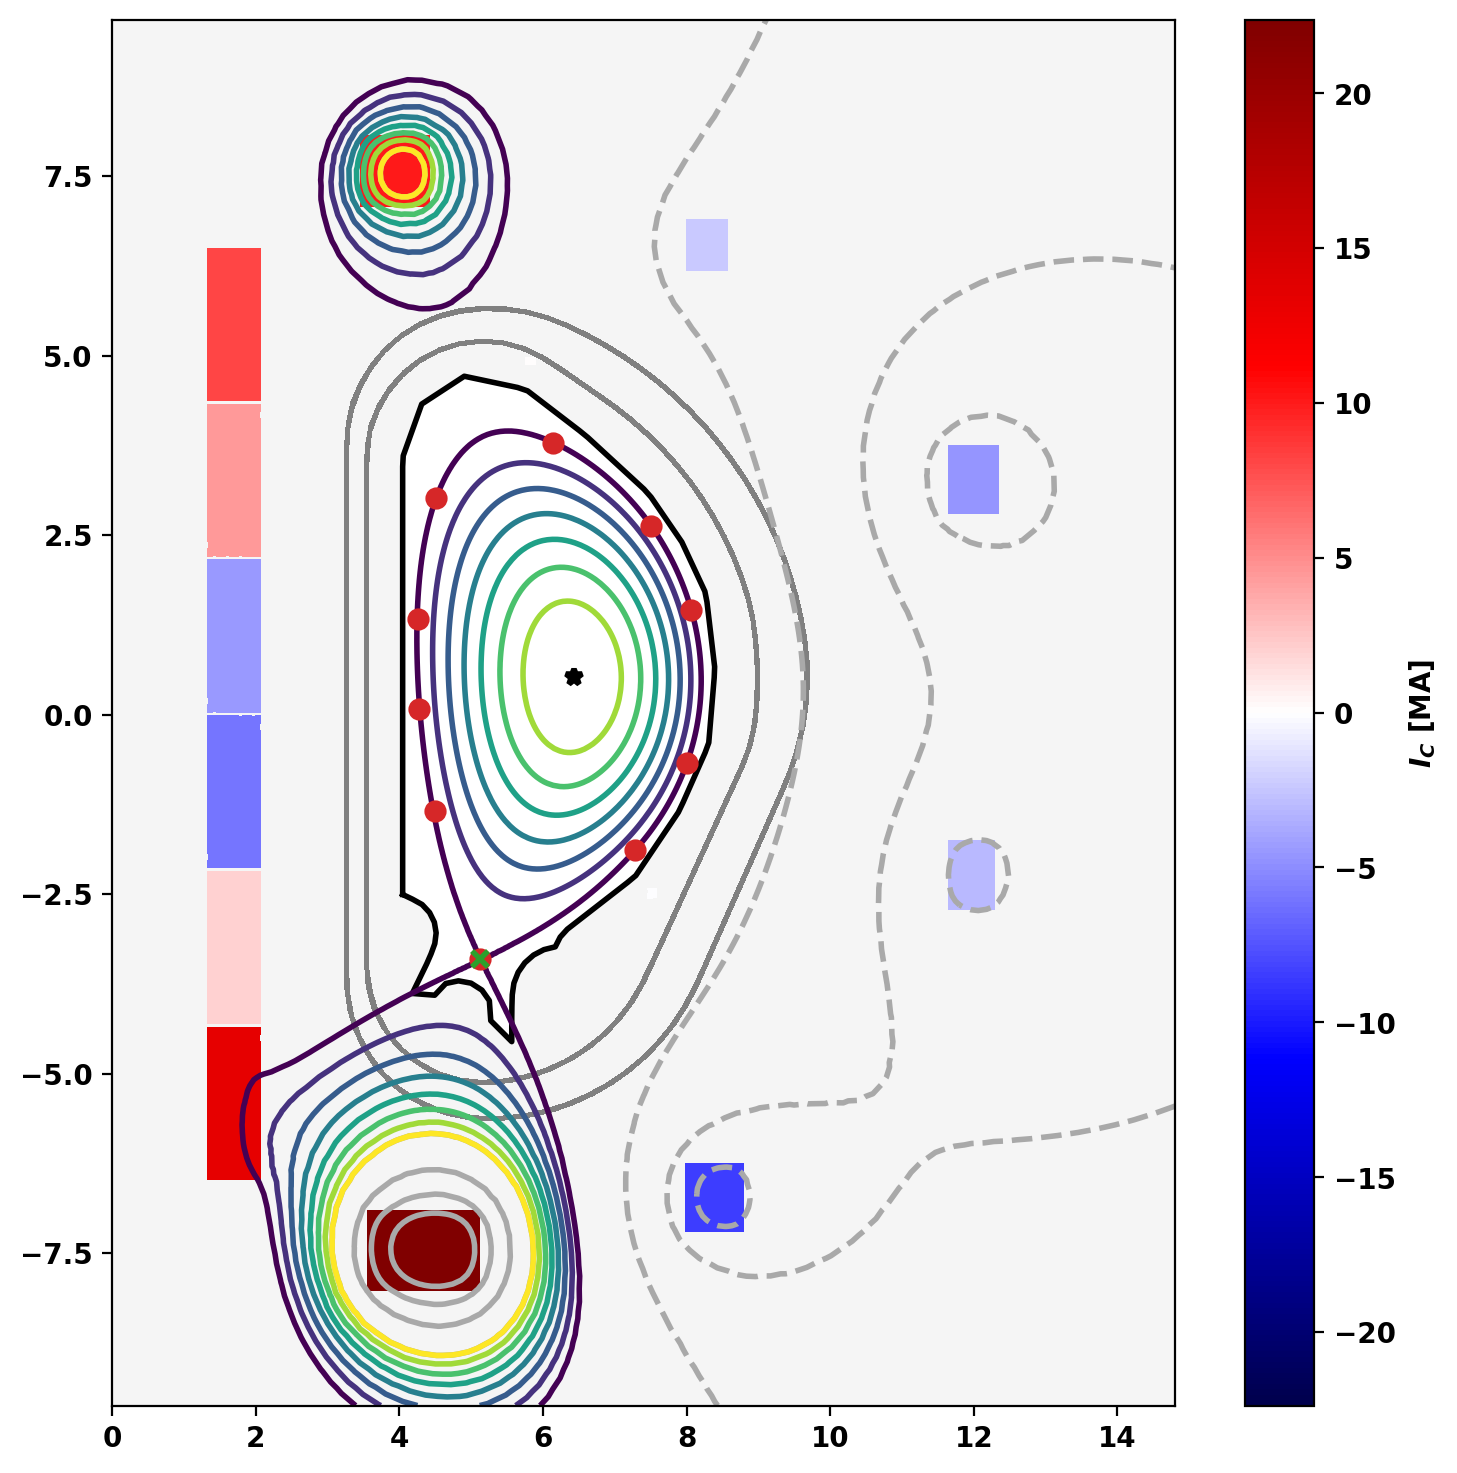

In [3]:
fig, ax = plt.subplots(1,1,figsize=(9,9))
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

mygs.print_info()

mygs.save_eqdsk(f'iter_hmode.eqdsk', cocos=2)

In [4]:
# load tm dict
tm_eqdsk = read_eqdsk('iter_hmode.eqdsk')
psi_N, q, geo, _, _, _ = mygs.get_q()
stats = mygs.get_stats()

tm_globals = mygs.get_globals()
tm = {
    'R': tm_eqdsk['rcentr'],
    'Z': tm_eqdsk['zaxis'],
    'B0': tm_eqdsk['bcentr'],
    'Ip': tm_eqdsk['ip'],
    'psi_axis': tm_eqdsk['psimag'],
    'psi_lcfs': tm_eqdsk['psibry'],

    'q_prof': q,
    'q_axis': q[0],
    'q_lcfs': q[-1],

    'vol_lcfs': stats['vol'],
    'R_inv_avg': geo[1],
    'R_avg': geo[0],
    
    'psi_N': psi_N,
}

tm['psi'] = psi_N * (tm['psi_lcfs'] - tm['psi_axis']) + tm['psi_axis']


In [5]:
# run TORAX with minimum input configuration
config_dict = {
    'plasma_composition': {
        'main_ion': {'D': 0.5, 'T': 0.5},
    },
    'geometry': {
        'geometry_type': 'eqdsk',
        'geometry_directory': os.getcwd(),
        'geometry_file': 'iter_hmode.eqdsk',
        'Ip_from_parameters': False,
        'cocos': 2,
        'last_surface_factor': 0.95
    },
    'numerics': {
        't_initial': 0.0,
        't_final': 0.001,
        'fixed_dt': 0.001,
        'evolve_ion_heat': False,
        'evolve_electron_heat': False,
        'evolve_current': False,
        'evolve_density': False,
    },
    'profile_conditions': {
        'normalize_n_e_to_nbar': False,
        'n_e_nbar_is_fGW': False,
        'initial_psi_from_j': False,
    },
    'sources': {},
    'pedestal': {
        'set_pedestal': False,
    },
    'transport': {
        'model_name': 'qlknn'
    },
    'solver': {
        'solver_type': 'newton_raphson',
        'use_pereverzev': True,
    },
    'numerics': {
        't_initial': 0.0,
        't_final': 0.001,
        'fixed_dt': {0.0: 0.001},  # Time-varying dict format
        'evolve_ion_heat': False,
        'evolve_electron_heat': False,
        'evolve_current': False,
        'evolve_density': False,
    },
}

config = torax.ToraxConfig.from_dict(config_dict)
data_tree, _ = torax.run_simulation(config)

2026-02-16 18:33:33,485 [ WARNING] User-specified COCOS 2 for EQDSK file has a (R, Z, phi) coordinate system (sigma_RphiZ = -1), but the EQDSK format specifies a (R, phi, Z) coordinate system (sigma_RphiZ = +1). This may result in unexpected behaviour.
2026-02-16 18:33:33,739 [ WARNING] Falling back to legacy behavior as `profile_conditions.psi` is None. Future versions of TORAX will require `psi` to be provided if `initial_psi_mode` is PROFILE_CONDITIONS. Use `initial_psi_mode` to initialize psi from `j` or `geometry` and avoid this warning.
Simulating (t=0.00100): 100%|██████████| 100/100 [00:00<00:00, 186.84it/s]


In [6]:
# pull_torax_onto_psi function interpolated TORAX profiles from rho_toroidal to psi_norm grid
def pull_torax_onto_psi(data_tree, var_name, psi_N, time, load_into_state='results', normalize=False, profile_type='linterp'):
    r'''! Load TORAX variable onto psi_norm grid.
    @param data_tree TORAX output data tree.
    @param var_name Name of variable (e.g., 'T_i', 'j_ohmic', 'FFprime').
    @param time Time value to extract.
    @param load_into_state If 'state' loads into '_state', elif 'results' loads into '_results', elif None, return (psi, data).
    @param normalize If True, normalize profile: subtract edge value, divide by core value (for FFprime, pprime).
    @param profile_type Type key for returned dict: 'linterp' or 'jphi-linterp'. Default is 'linterp'.
    '''
    
    # Extract variable from profiles
    var = getattr(data_tree.profiles, var_name)
    var_data = var.sel(time=time, method='nearest').to_numpy()
    
    # Automatically detect which rho coordinate this variable uses
    if 'rho_cell_norm' in var.coords:
        grid = 'rho_cell_norm'
    elif 'rho_face_norm' in var.coords:
        grid = 'rho_face_norm'
    elif 'rho_norm' in var.coords:
        grid = 'rho_norm'
    else:
        raise ValueError(f"Variable {var_name} does not have a recognized rho coordinate")
    
    # Get rho_tor coordinate for this variable
    rho_tor = var.coords[grid].values
    
    # Get psi_norm on rho_face_norm grid and psi on rho_norm grid
    psi_norm_face = data_tree.profiles.psi_norm.sel(time=time, method='nearest').to_numpy()
    psi_rho_norm = data_tree.profiles.psi.sel(time=time, method='nearest').to_numpy()
    psi_norm_rho_norm = (psi_rho_norm - psi_rho_norm[0]) / (psi_rho_norm[-1] - psi_rho_norm[0])
    
    # Correct second element to avoid degeneracy from zero-gradient BC at core
    psi_norm_rho_norm[1] = (psi_norm_face[0] + psi_norm_face[1]) / 2.0

    # Convert psi to same grid as variable
    if grid == 'rho_cell_norm':
        psi_on_grid = psi_norm_rho_norm[1:-1]
    elif grid == 'rho_face_norm':
        psi_on_grid = psi_norm_face
    elif grid == 'rho_norm':
        psi_on_grid = psi_norm_rho_norm
        
    # Interpolate onto uniform psi grid
    data_on_psi = interp1d(psi_on_grid, var_data, kind='linear',
                        fill_value='extrapolate', bounds_error=False)(psi_N)

    
    # Normalize if requested
    if normalize:
        if grid == 'rho_cell_norm':
            # Cell-centered variables don't have a value at psi=0
            # Find the index in data_on_psi closest to the first cell center
            core_idx = np.argmin(np.abs(psi_N - psi_on_grid[0]))
            data_on_psi /= data_on_psi[core_idx]
        else:
            # Face or extended grid has actual core value at psi=0
            data_on_psi /= data_on_psi[0]
    
    if load_into_state == 'state':
        return {'x': psi_N.copy(), 'y': data_on_psi.copy(), 'type': profile_type}
    elif load_into_state == 'results':
        return data_on_psi.copy()
    else:
        return data_on_psi

In [7]:
# load tx dict
t=0
tx={
    'R': data_tree.scalars.R_major.sel(time=t, method='nearest'),
    'Z': data_tree.scalars.z_magnetic_axis.sel(time=t, method='nearest'),
    'B0': data_tree.scalars.B_0.sel(time=t, method='nearest'),
    'Ip': data_tree.scalars.Ip.sel(time=t, method='nearest'),
    'psi_axis': data_tree.profiles.psi.sel(time=t, method='nearest').to_numpy()[0],
    'psi_lcfs': data_tree.profiles.psi.sel(time=t, method='nearest').to_numpy()[-1],
    
    'q_prof': pull_torax_onto_psi(data_tree, 'q', psi_N, time=t),
    'q_axis': pull_torax_onto_psi(data_tree, 'q', psi_N, time=t)[0],
    'q_lcfs': pull_torax_onto_psi(data_tree, 'q', psi_N, time=t)[-1],

    'vol_lcfs': data_tree.profiles.volume.sel(time=t, method='nearest').to_numpy()[-1],
    'R_inv_avg': pull_torax_onto_psi(data_tree, 'gm9', psi_N, time=t),

    'psi_N': pull_torax_onto_psi(data_tree, 'psi_norm', psi_N, time=t),
    'psi': pull_torax_onto_psi(data_tree, 'psi', psi_N, time=t) / (2.0 * np.pi),
    'psi_from_geo': pull_torax_onto_psi(data_tree, 'psi_from_geo', psi_N, time=t) / (2.0 * np.pi),
    'psi_from_Ip': pull_torax_onto_psi(data_tree, 'psi_from_Ip', psi_N, time=t) / (2.0 * np.pi),
}

In [8]:
# comparison table for scalar values
import pandas as pd

# Identify common keys
tm_keys = set(tm.keys())
tx_keys = set(tx.keys())
common_keys = tm_keys & tx_keys

scalar_keys = []
profile_keys = []

for key in common_keys:
    if isinstance(tm[key], (int, float, np.integer, np.floating)):
        scalar_keys.append(key)
    elif hasattr(tm[key], '__len__'):
        profile_keys.append(key)

comparison_data = []
for key in sorted(scalar_keys):
    tm_val = float(tm[key])
    tx_val = float(tx[key])
    diff = tx_val - tm_val
    ratio = tx_val / tm_val  if tm_val != 0 else np.nan
    comparison_data.append({
        'Parameter': key,
        'TokaMaker': f'{tm_val:.4}',
        'TORAX': f'{tx_val:.4}',
        'Difference': f'{diff:.4}',
        '    TM/TX ratio': f'{ratio:.2f}' if not np.isnan(ratio) else 'N/A'
    })

df = pd.DataFrame(comparison_data)

# print(df.to_string(index=False))
display(df)

,Parameter,TokaMaker,TORAX,Difference,TM/TX ratio
0,B0,5.363,5.363,0.0,1.00
1,Ip,1.3e+07,1.301e+07,1.116e+04,1.00
2,R,6.226,6.226,2.35e-07,1.00
3,Z,0.5264,0.5264,0.0,1.00
4,psi_axis,-19.28,-121.0,-101.7,6.28
5,psi_lcfs,-10.02,-66.61,-56.59,6.65
6,q_axis,1.396,1.468,0.07248,1.05
7,q_lcfs,3.884,3.164,-0.7195,0.81
8,vol_lcfs,816.1,737.2,-78.95,0.90


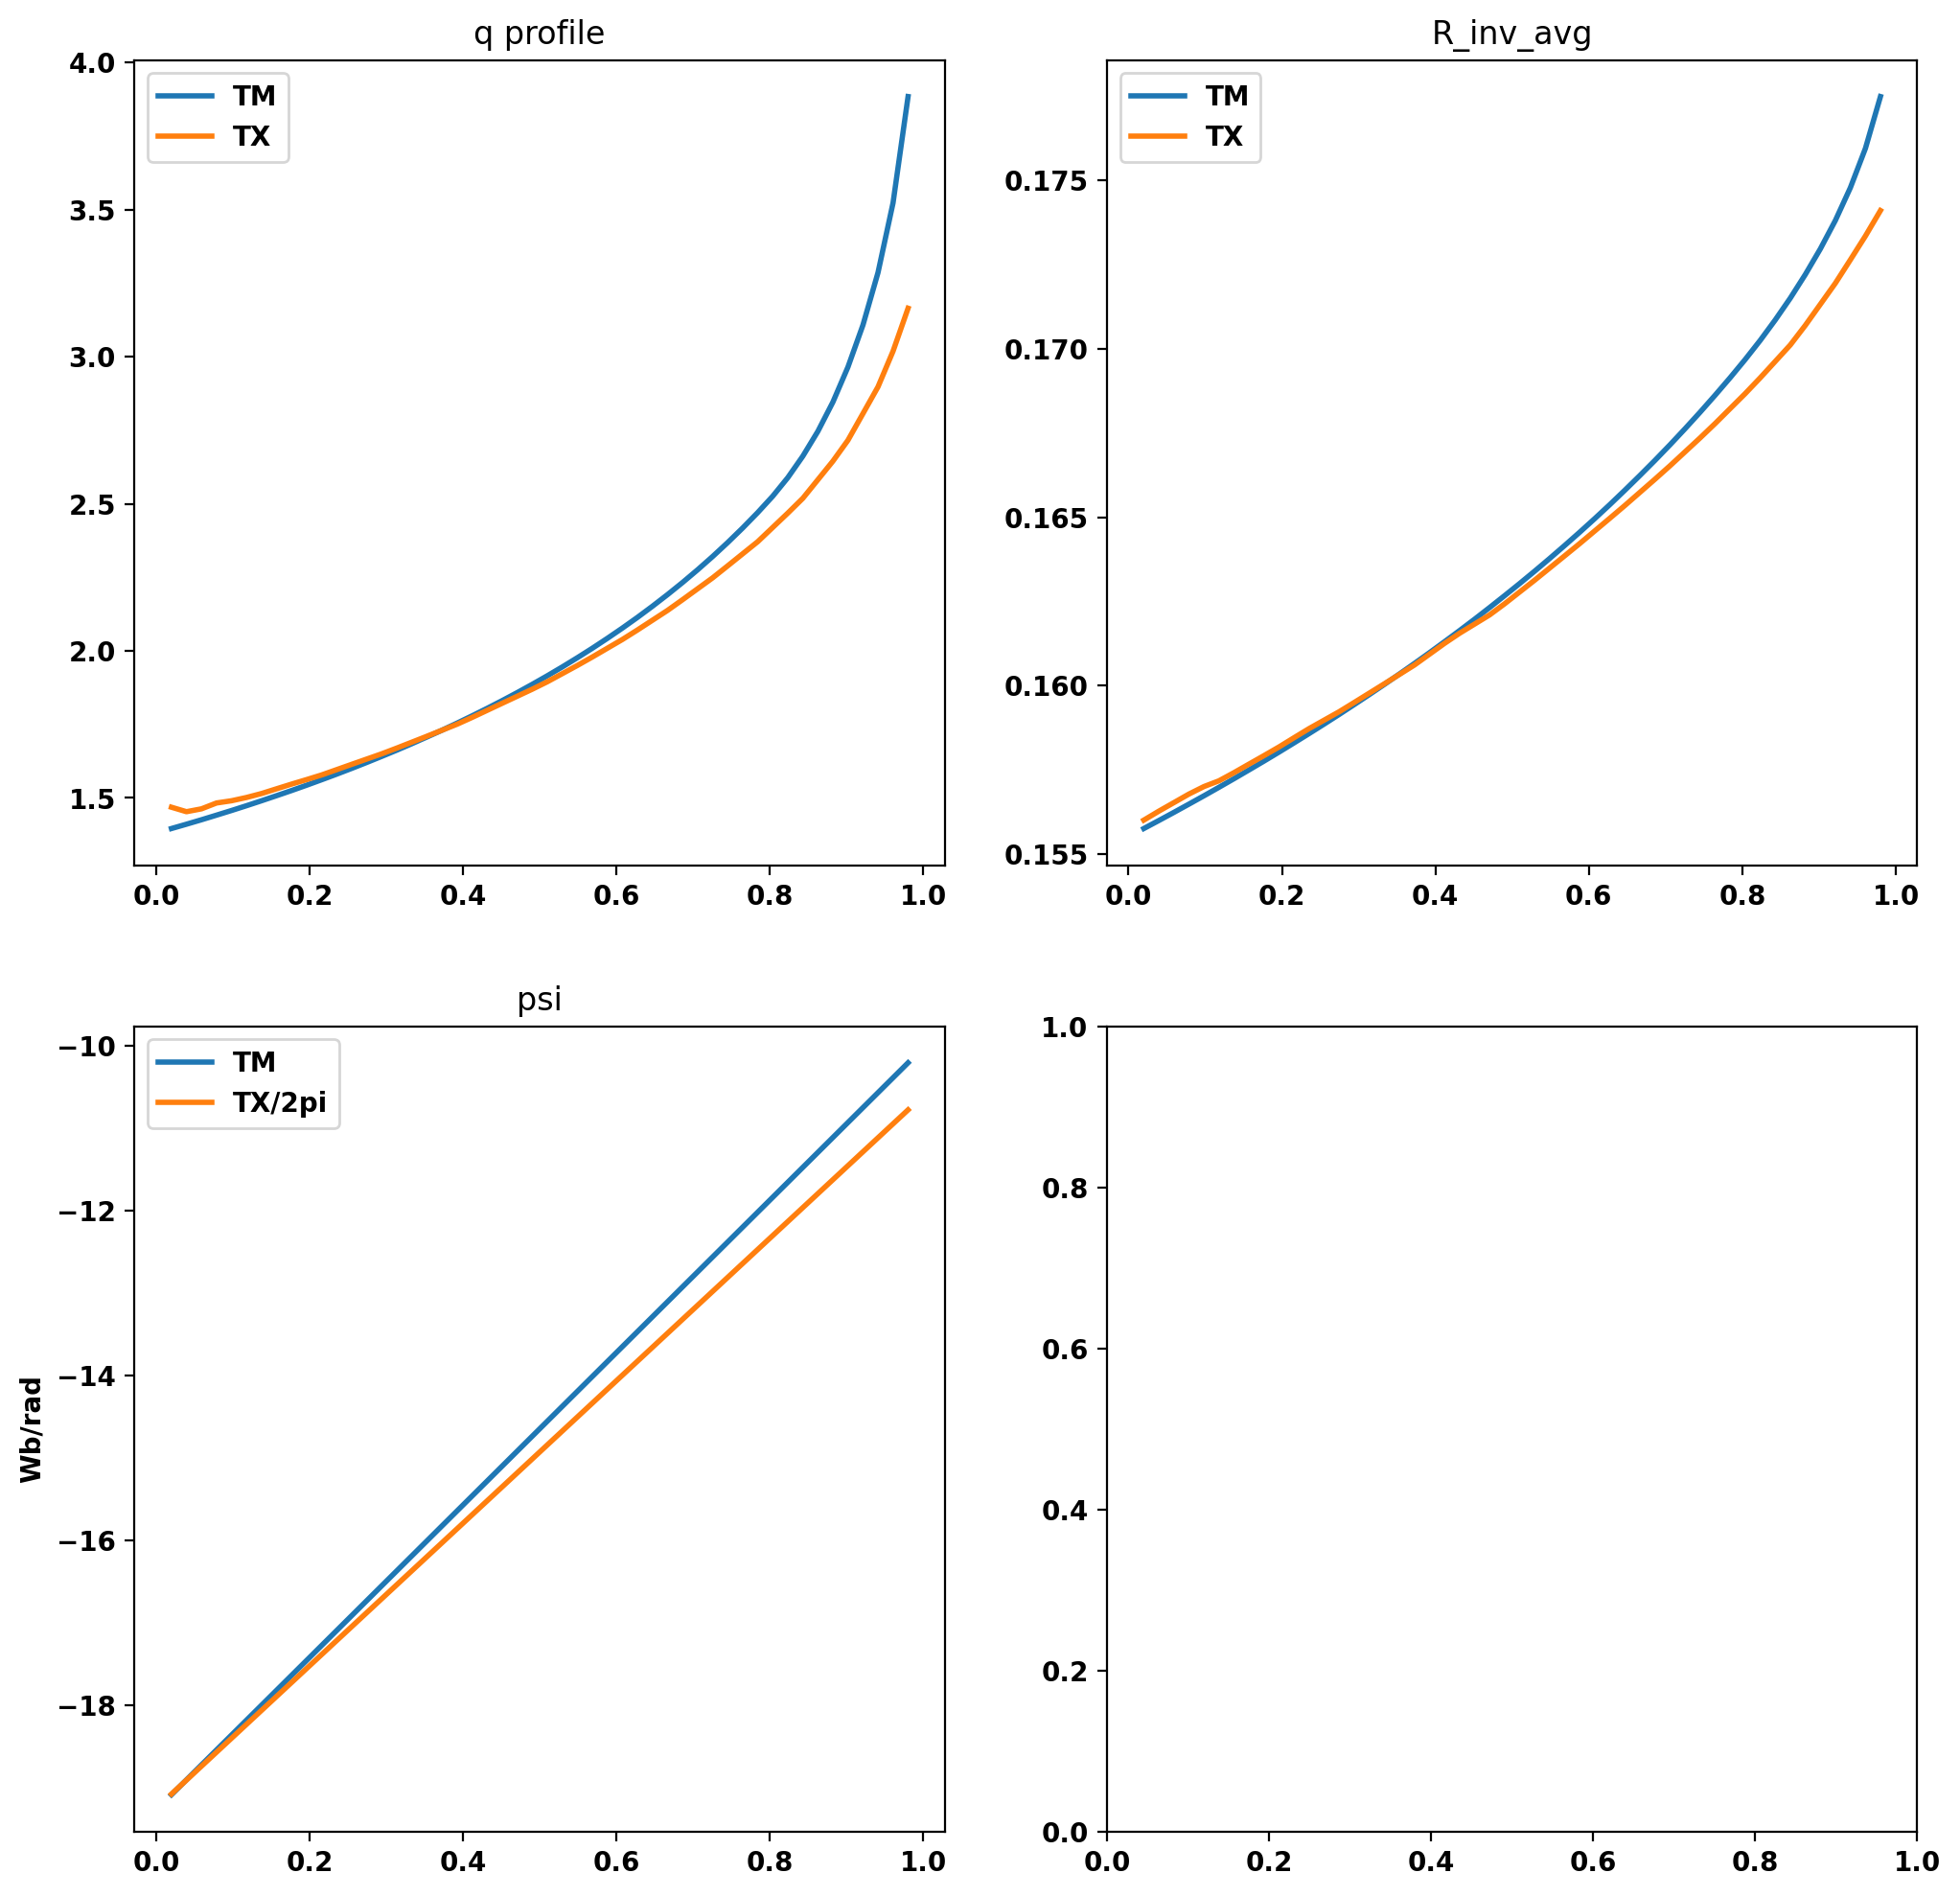

In [9]:
fig, axes = plt.subplots(2,2,figsize=(12,12))

ax00 = axes[0,0]
ax01 = axes[0,1]
ax10 = axes[1,0]
ax11 = axes[1,1]

ax00.set_title('q profile')
ax00.plot(tm['psi_N'], tm['q_prof'], label='TM')
ax00.plot(tx['psi_N'], tx['q_prof'], label='TX')
ax00.legend()

ax01.set_title('R_inv_avg')
ax01.plot(tm['psi_N'], tm['R_inv_avg'], label='TM')
ax01.plot(tx['psi_N'], tx['R_inv_avg'], label='TX')
ax01.legend()

ax10.set_title('psi')
ax10.plot(tm['psi_N'], tm['psi'], label='TM')
ax10.plot(tx['psi_N'], tx['psi'], label='TX/2pi')
ax10.set_ylabel('Wb/rad')
ax10.legend()